# Unit Hydrograph Determination
*Transformation of a melt timeseries to discharge using a unit hydrograph to simulate routing.*  

Written by C. Trunz & J. Mejia  
last update: July 2021

### Model Inputs
- Meltwater production (mm water equivalent per timestep).
    Calculated using meterological measurements from on-ice weather stations[^1] and the enhanced temperature-index melt model.[^2]
- Emperically defined parameters
 
    



### Synthetic Unit Hydrograph (SUH)
The SUH is based on King, L. A. (2018).[^3] 
which is based on Smith, L. C., et al. (2017).[^4] 
!!! in Smith et al. 2017, there is a mistake in the equation described in the supplemental. So we use the equation from King 2018.

[^1]: Mejia, J., Trunz, C., Gulley, J., & Covington, M. (2021). Surface meltwater production timeseries for Sermeq Avannarleq, western Greenland Ice Sheet from 2017-2018. [Data set]. *In Arctic Data Center.* https://doi.org/10.18739/A2V97ZS6G  
[^2]: Pellicciotti, F., Brock, B., Strasser, U., Burlando, P., Funk, M., & Corripio, J. (2005). An enhanced temperature-index glacier melt model including the shortwave radiation balance : development and testing for Haut Glacier d ’Arolla , Switzerland. Journal of Glaciology, 51(175), 573–587. https://doi.org/10.3189/172756505781829124
[^3]: King, L. A. (2018). Comparing two methods of remotely estimating moulin discharge on the Greenland ice sheet. Journal of Glaciology, 1–5. https://doi.org/10.1017/jog.2018.65
[^4]: Smith, L. C., et al. (2017). Direct measurements of meltwater runoff on the Greenland ice sheet surface. PNAS, 114(50), E10622–E10631. https://doi.org/10.1073/pnas.1707743114

In [1]:
import datetime
from datetime import datetime as dt 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits

# %matplotlib widget

In [2]:
# format matplotlib dates
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[dt] = converter

## Import datasets
1. Melt timeseries for Low Camp (LOWC) and High Camp (HIGH) weather stations
2. Discharge timeseries for each catchment 

In [4]:
#import low camp melt and weather
lowc = pd.read_csv('LOWC17_MELT_NEW.csv', 
                   index_col=0, 
                   parse_dates=True)
#high = pd.read_csv('HIGH_MELT_2017_2018.csv', 
#                   index_col=0, 
#                   parse_dates=True)

# import discharge measurements for plotting and SUH calibration
JEME = pd.read_csv('JEME_Qdye.csv', index_col=0, parse_dates=True)
#JNIH = pd.read_csv('JNIH_Qdye.csv', index_col=0, parse_dates=True)
#RADI = pd.read_csv('RADI_Qdye.csv', index_col=0, parse_dates=True)
PIRA = pd.read_csv('PIRA_Q.csv', index_col=0, parse_dates=True, header=[0,1])
#SBPI = pd.read_csv('SBPI_QIR.csv', index_col=0, parse_dates=True)

data_dic = {'JEME': JEME, 
            #'JNIH': JNIH,
            #'RADI': RADI,
            'PIRA': PIRA,
            #'SBPI': SBPI
           }

In [8]:
PIRA.columns

MultiIndex([(    'Dye',          'Discharge (m^3/s)'),
            (    'Dye',        'Concentration (ppb)'),
            ('ice_ray',                  'Level (m)'),
            ('ice_ray',             'Velocity (m/s)'),
            ('ice_ray',          'Discharge (m^3/s)'),
            ('ice_ray', 'Discharge smoothed (m^3/s)')],
           )

In [9]:
PIRA['ice_ray']['Discharge smoothed (m^3/s)']

2018-07-09 19:30:00    0.28620
2018-07-09 19:45:00    0.31575
2018-07-09 20:00:00    0.32378
2018-07-09 20:15:00    0.31805
2018-07-09 20:30:00    0.30447
                        ...   
2018-07-19 19:28:00    0.73582
2018-07-19 19:29:00    0.73404
2018-07-19 19:30:00    0.73226
2018-07-19 19:31:00    0.73049
2018-07-19 19:32:00    0.72873
Name: Discharge smoothed (m^3/s), Length: 9901, dtype: float64

In [10]:
PIRA.columns

MultiIndex([(    'Dye',          'Discharge (m^3/s)'),
            (    'Dye',        'Concentration (ppb)'),
            ('ice_ray',                  'Level (m)'),
            ('ice_ray',             'Velocity (m/s)'),
            ('ice_ray',          'Discharge (m^3/s)'),
            ('ice_ray', 'Discharge smoothed (m^3/s)')],
           )

3. Parameters for the Unit Hydrograph model  

 `param_SUH`  (pd.DataFrame) 
 
 column | dtype | unit | description 
 -----: | :---: | :--: | ---------
 `index` |str | | Terminal moulin/catchment name   
 `camp`  |str | | catchment location  
 `year`  |int | | year of observations   
 `db`   |float| km^2 | drainage basin area in square km  
 `c`    |float| | adjustment coefficient
 `Cp`   |float|-|  
 `m`    |float| | empiriically derived adjustment factor
 `tp`   |float| hrs | time to peak discharge  
 `hp`   |float| hr^-1| peak discharge = Cp / tp

### synthetic hydrograph unit

We calculate a synthetic unit hydrograph (SUH) curve to determine moulin discharge *q* in (hr$^{-1}$) at time *t* using:  
*q*(*t*) = *e*$^m$ ($\frac{t}{tp}$)$^m$   e$^{-m \frac{t}{tp}}$   $h_p$




In [35]:
#import SUH parameters
param_SUH = pd.read_csv('param_SUH.csv',index_col=0)
param_SUH.at['JEME','Cp'] = 1
param_SUH.at['JEME','db'] = 0.5
param_SUH['hp'] = np.round(param_SUH['Cp']/param_SUH['tp'],3)
param_SUH



,camp,year,db,c,Cp,m,tp,hp
Moulin,,,,,,,,
JNIH,low,2017,1.1,0.4,0.6,2.5,4.2,0.143
JEME,low,2017,0.5,0.9,1.0,1.0,2.6,0.385
PIRA,low,2018,0.5,0.9,1.0,1.0,2.6,0.385
RADI,high,2017,16.8,0.4,0.6,2.5,6.5,0.092
SBPI,high,2018,2.4,0.6,0.6,1.0,5.0,0.120


## Calculate SUH and resulting discharge timeserie

#### define functions to implement SUH equations

In [41]:
# define functions to implement SUH equations
def synthetic_unit_hydrograph(m, tp, hp):
    """create the SUH q-curve with empirical values for each catchment. 
    
    SUH: synthetic unit hydrograph
        update SUH with empirical values m, tp, and hp
    Implements the equation used by King (2018) pp 41.
    
    Parameters
    ----------
        m (float, np.array) : empirical equation shape factor
        tp (np.array) : time to peak discharge (hrs)
        hp (np.array): peak discharge (hr^-1)
        
    Returns
    -------
        q (np.array) : q-curve units of m/hr
    """
    return (np.exp(m) * (np.arange(25) / tp) ** m 
            * (np.exp( -m * (np.arange(25) / tp))) * hp )

def calc_QSUH(melt, moulin_name, visualize=False):
    """Calculate discharge using the synthetic unit hydrograph for melt timeseries.
    
    Parameters
    ----------
        melt (pd.Series) : melt timeseries
        const (np.array, pd.df, pd.series) : constants needed for SUH
    
    
    Returns
    -------
        Q (np.array) : Discharge calculated with SUH (m^3/s)
        
    """
    param = param_SUH.loc[moulin_name]

    #calc UH
    # M' effective 
    # units: mm/h
    runoff = melt* param.c 
    
    # Synthetic Unit Hydrograph - King (2018)
    SUH = synthetic_unit_hydrograph(param.m, 
                                    param.tp, 
                                    param.hp)
    # convolution of runoff and the unit hydrograph q-curve
    # Q = M' * q where * is the convolution operator (np.convolve)
    q = np.convolve(runoff,SUH)
    # remove the adds 23 additional values
    q = q[0:-24] 
    # multiply by drainage basin area and convert 
    # runoff from mm per hour to cubic meters per second
    # <Note!> Before this point, units are in 1/hours.
    Q = q * param.db*1e3/3600
    Q = pd.Series(data=Q,index=runoff.index).rename(moulin_name)
    
    if visualize:
        gen_figs(SUH, Q, moulin_name)
    
    return Q

def gen_figs(SUH, Q, name):
    ice_ray = True if name in ['PIRA','SBPI'] else False
    if name == 'PIRA':
        col = ("ice_ray","Discharge smoothed (m^3/s)")
    elif name == 'SBPI':
        col = "Discharge smoothed (m^3/s)"
    return calibration_figs(SUH, Q, name, col=col
                           ) if ice_ray else calibration_figs(SUH, Q, name)

def calibration_figs(SUH, Q, m_name, data=data_dic, col='Discharge_m^3/s'):
    """Plot unit hydrograph and compare calculated and measured Q values."""
    df = data_dic.get(m_name)
    fig=plt.figure(tight_layout=True, figsize=(8,6))
    ax1 = fig.add_subplot(211, 
                          ylabel='q', 
                          xlabel='hours', 
                          title=f'{m_name}')
    ax1.plot(np.arange(25),SUH)
    ax2 = fig.add_subplot(212, ylabel='Q m$^3$/s')
    ax2.plot(Q,label='modeled')
    ax2.plot(df[col],'.',markersize=1, color='.6', label='measured')
    ax2.legend()
    ax2.set_xlim(df.index[0]-pd.Timedelta('12H'),df.index[-1]+pd.Timedelta('12H'))
    

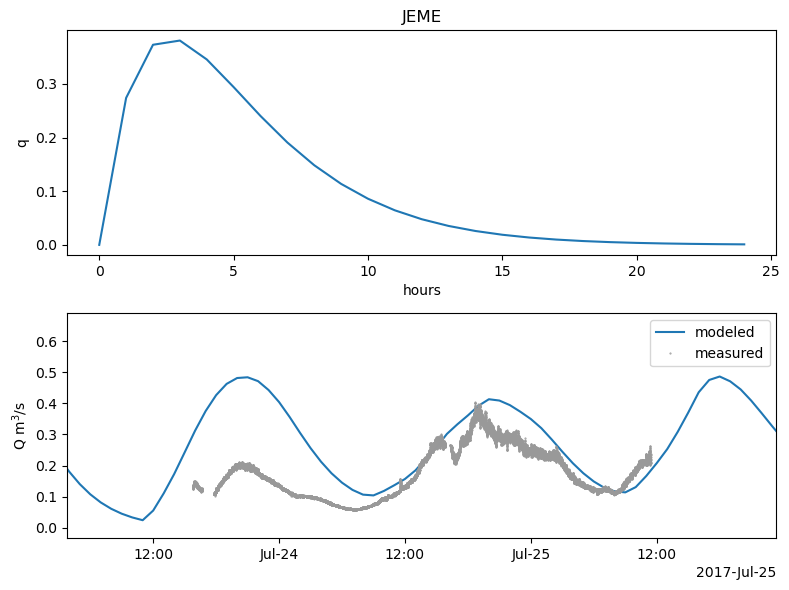

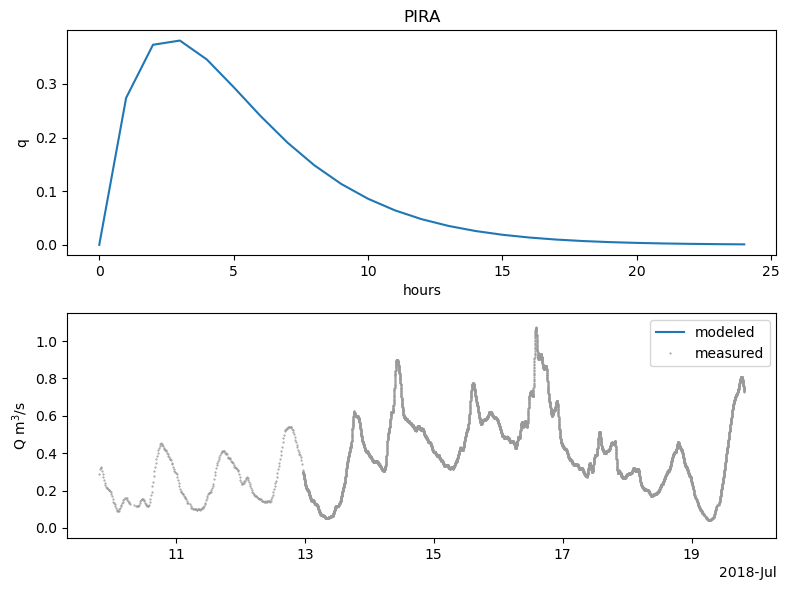

In [46]:
#import SUH parameters
param_SUH = pd.read_csv('param_SUH.csv',index_col=0)
param_SUH.at['JEME','Cp'] = 1
param_SUH.at['PIRA','Cp'] = 1
param_SUH.at['JEME','db'] = 0.3
param_SUH.at['PIRA','db'] = 0.5
param_SUH.at['JEME','c'] = 0.9
param_SUH.at['PIRA','c'] = 0.9
param_SUH.at['JEME','m'] = 1
param_SUH.at['PIRA','m'] = 1

param_SUH['hp'] = np.round(param_SUH['Cp']/param_SUH['tp'],3)
param_SUH


Q_JNIH = calc_QSUH(lowc.melt_rate,'JNIH').loc['2017']
Q_JEME = calc_QSUH(lowc.melt_rate,'JEME', visualize=True).loc['2017']
#Q_RADI = calc_QSUH(high.melt_rate,'RADI', visualize=True).loc['2017']

Q_PIRA = calc_QSUH(lowc.melt_rate,'PIRA', visualize=True).loc['2018']
#Q_SBPI = calc_QSUH(high.melt_rate,'SBPI').loc['2018']



In [ ]:
# create a single dataframe and export to csv for archiving
Q_RADI.to_frame().join(Q_JEME).join(Q_JNIH).join(
    Q_PIRA,how='outer').join(Q_SBPI,how='outer').to_csv(
    'Q_SUH.csv',na_rep='NaN')

### Generatre figures

In [ ]:
fig=plt.figure(figsize=(10,12))
ax=fig.add_subplot(211,ylabel='Q (m$^3$/s)',title='2017')
#ax.plot(Q_RADI,label='RADI')
#ax.plot(Q_JNIH,label='JNIH')
ax.plot(Q_JEME,color='orangered',label='JEME')
ax.legend(['RADI','JNIH','JEME'])
ax.set_xlim(pd.Timestamp('2017-4-15'),pd.Timestamp('2017-10-15'))
ax2=fig.add_subplot(212,ylabel='Q (m$^3$/s)',ylim=ax.get_ylim(),title='2018')
#ax2.plot(Q_SBPI,label='SBPI')
ax2.plot(Q_PIRA,label='PIRA')
ax2.set_xlim(pd.Timestamp('2018-4-15'),pd.Timestamp('2018-10-15'))
ax2.legend()

In [ ]:
print('Average discharge values\n 2017')
print(f'     RADI  {Q_RADI["2017-7-6":"2017-8-16"].mean():.3f} m^3/d')
print(f'     JEME  {Q_JEME["2017-7-6":"2017-8-16"].mean():.3f} m^3/d')
print(f'     JNIH  {Q_JNIH["2017-7-6":"2017-8-16"].mean():.3f} m^3/d\n 2018')
print(f'     SBPI  {Q_SBPI["2018-7-10":"2018-8-22"].mean():.3f} m^3/d')
print(f'     PIRA  {Q_PIRA["2018-7-10":"2018-8-22"].mean():.3f} m^3/d')